# Example
#### Notebook with examples of using different submodules of our KBQA system

In [1]:
from wikidata.wikidata_entity_to_label import WikidataEntityToLabel
from caches.genre import GENREWikidataEntityesCache
from wikidata.wikidata_shortest_path import WikidataShortestPathCache
from wikidata.wikidata_label_to_entity import WikidataLabelToEntity
from wikidata.wikidata_redirects import WikidataRedirectsCache
from wikidata.wikidata_property import WikidataProperty

# WikidataEntityToLabel

In [2]:
entity2label = WikidataEntityToLabel(
    sparql_endpoint="http://localhost:7200/repositories/wikidata"
)
print(entity2label.get_label("Q30"))

United States of America


# WikidataLabelToEntity

In [3]:
redirect_cache = WikidataRedirectsCache(cache_dir_path="./cache_store")
label2entity = WikidataLabelToEntity(
    redirect_cache=redirect_cache,
    cache_dir_path="./cache_store",
    sparql_endpoint="http://localhost:7200/repositories/wikidata",
)

print(label2entity.get_id("Paris"))

Q90


# WikidataShortestPathCache

In [4]:
shortest_path = WikidataShortestPathCache(
    sparql_endpoint="http://localhost:7200/repositories/wikidata",
    engine="graphdb",
)
pathes = shortest_path.get_shortest_path(
    "Q22686",
    "Q90",
    return_edges=False,
    return_only_first=False,
    return_id_only=True,
)
pathes

[['Q22686', 'Q61', 'Q90']]

## WikidataProperty

In [5]:
wikidata_property = WikidataProperty()
wikidata_property.get_properties_between("Q30", "Q16", True)

['P47', 'P530']

# mGENRE

Firstly, clone https://github.com/SergeyPetrakov/mGENRE_MEL and check **mGENRE_and_Uncertainty_Estimation.ipynb** with preparation GENRE model steps

After that, you will have mGENRE_MEL directory with all that you need for **GENREWikidataEntityesCache module**

In [1]:
import os

os.environ["PYTHONPATH"] = "/fairseq/"

import pickle
import torch
from genre.trie import Trie, MarisaTrie
from genre.fairseq_model import mGENRE

with open("./lang_title2wikidataID-normalized_with_redirect.pkl", "rb") as f:
    lang_title2wikidataID = pickle.load(f)

with open("./titles_lang_all105_marisa_trie_with_redirect.pkl", "rb") as f:
    trie = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mGENRE = mGENRE.from_pretrained(
    "./fairseq_multilingual_entity_disambiguation"
).eval()
model_mGENRE.to(device)
print("mGENRE loaded")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mGENRE loaded


In [ ]:
genre_entityes = GENREWikidataEntityesCache(
    model_mGENRE,
    trie,
    lang_title2wikidataID,
)
genre_entityes.sentences_batch_to_entities(
    [
        "[START] in what french city did antoine de févin die  [END]",
        "[START] What job does jamie hewlett have [END]",
    ]
)

# Subgraph Extraction

Visualization can be viewed at visualization/subgraph.svg


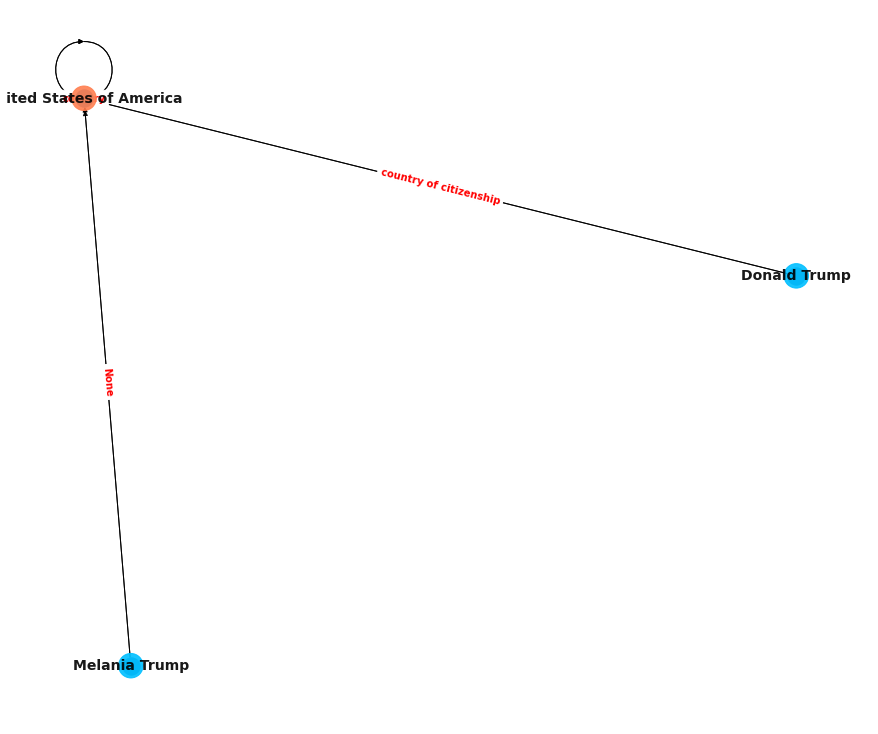

In [6]:
from wikidata.wikidata_subgraphs_retriever import SubgraphsRetriever
from wikidata.wikidata_entity_to_label import WikidataEntityToLabel
from wikidata.wikidata_shortest_path import WikidataShortestPathCache
import matplotlib.pyplot as plt
import os


# sample question: in what french city did antoine de févin die
E1 = "Q22686"  # Doland Trump
E2 = "Q432473"  # Melania Trump
Es = [E1, E2]

C = "Q30"  # USA
entity2label = WikidataEntityToLabel()
shortest_path = WikidataShortestPathCache()
subgraph_obj = SubgraphsRetriever(entity2label, shortest_path, edge_between_path=False)
subgraph = subgraph_obj.get_subgraph(Es, C, number_of_pathes=3)
ax = subgraph_obj.visualize_subgraph(subgraph)

path = "visualization"
if not os.path.exists(path):
    os.makedirs(path)

plt.savefig(path + "/sub.svg")
print("Visualization can be viewed at visualization/subgraph.svg")